In [1]:
!pip install note_seq
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.6 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for protobuf>=4.21.2 from https://files.pythonhosted.org/packages/ae/5b/7ed02a9b8e752c8f7bca8661779c0275b9e3e6a903a3045e6da51f796dda/protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for mido>=1.1.16 from https://files.pythonhosted.org/packages/b0/0e/b551e09391220208764c00ed2b382e198414329d8b6037eeb54a8008d737/mido-1.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for packaging>=16.8 from https://files.pythonhosted.org/packages/ec/1a/610693ac4ee14fcdf2d9bf3c493370e4f2ef7ae2e19217d7a237ff42367d/packaging-23.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import math
import os
import glob
import time

import numpy as np
import librosa
import note_seq
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Bidirectional, GRU, Dense , Dropout, BatchNormalization, Input, Flatten, Reshape, GlobalAveragePooling1D

import warnings
warnings.filterwarnings('ignore')

In [3]:
len_seq = 0.1

In [4]:
MIDI_paths = []
MP3_paths = []

for name in glob.glob('/kaggle/input/themaestrodatasetv2/maestro-v2.0.0/2004/*.midi'):
    MIDI_paths.append(name)
    MP3_paths.append(name[:-4] + 'mp3')

In [6]:
def preprocess_wave_and_midi(MIDI_path, MP3_path, len_seq):
    
    y, sr = librosa.load(MP3_path)
    
    ns = note_seq.midi_file_to_sequence_proto(MIDI_path)
    
    start_len = 0
    end_len =ns.notes[len(ns.notes) -1].end_time
    
    x = [i.pitch for i in ns.notes]
    min_pitch = min(x)
    max_pitch = max(x)
    
    time_step = np.arange(start_len, end_len, 0.01)
    
    onehot = np.zeros((len(time_step), 128))
    
    for i in ns.notes:
        note = i.pitch
        for x in range(int(i.start_time*100), int(i.end_time*100)):
            onehot[x, note] = i.velocity
            
    num_batches = math.ceil(len(y) / (sr * len_seq))
    
    for _ in range(int(num_batches * len_seq * 100) - len(onehot)):
        onehot = np.append(onehot, [np.zeros((128))], axis = 0)
        
    onehot = onehot.reshape(num_batches, int(len_seq * 100), 128)
    
    y = np.pad(y, (0, int(sr * len_seq * num_batches)-len(y) ), 'constant')
    
    input_data = y.reshape(num_batches, int(len_seq * sr))
    
    return input_data, onehot


In [7]:
N_files = 25

X = []
Y = []

for a,b in zip(MIDI_paths[:N_files], MP3_paths[:N_files]):
    input_data, output_data = preprocess_wave_and_midi(a,b, len_seq)
    X.append(input_data)
    Y.append(output_data)
    
X = np.concatenate(X, axis = 0)
Y = np.concatenate(Y, axis = 0)

In [8]:
X = X.reshape(X.shape[0], 1, int(22050 * len_seq))

In [9]:
model = keras.Sequential()

model.add(Input(shape=(1, (int(22050 * len_seq)))))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(512, activation='relu', return_sequences=True))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(100 * len_seq * 128))
model.add(Reshape((int(len_seq * 100), 128)))

model.summary()
model.compile(loss='MSE', optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            2521088   
                                                                 
 batch_normalization (Batch  (None, 1, 256)            1024      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 1, 512)            1574912   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [24]:
history = model.fit(x = X, y = Y, batch_size = 64, epochs = 30, validation_split=0.05, shuffle=False)

Epoch 1/30
2063/2063 [==============================] - 85s 41ms/step - loss: 33.4080 - val_loss: 59.0269
Epoch 2/30
2063/2063 [==============================] - 81s 39ms/step - loss: 33.0702 - val_loss: 58.8961
Epoch 3/30
2063/2063 [==============================] - 78s 38ms/step - loss: 32.6938 - val_loss: 58.7104
Epoch 4/30
2063/2063 [==============================] - 78s 38ms/step - loss: 32.4482 - val_loss: 58.8912
Epoch 5/30
2063/2063 [==============================] - 79s 38ms/step - loss: 32.0741 - val_loss: 58.7280
Epoch 6/30
2063/2063 [==============================] - 79s 38ms/step - loss: 31.7936 - val_loss: 58.9916
Epoch 7/30
2063/2063 [==============================] - 78s 38ms/step - loss: 31.4711 - val_loss: 58.6737
Epoch 8/30
2063/2063 [==============================] - 79s 38ms/step - loss: 31.2519 - val_loss: 58.8287
Epoch 9/30
2063/2063 [==============================] - 76s 37ms/step - loss: 31.0397 - val_loss: 58.9216
Epoch 10/30
2063/2063 [=======================

In [25]:
model.save('model_LSTM2.h5')

In [26]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

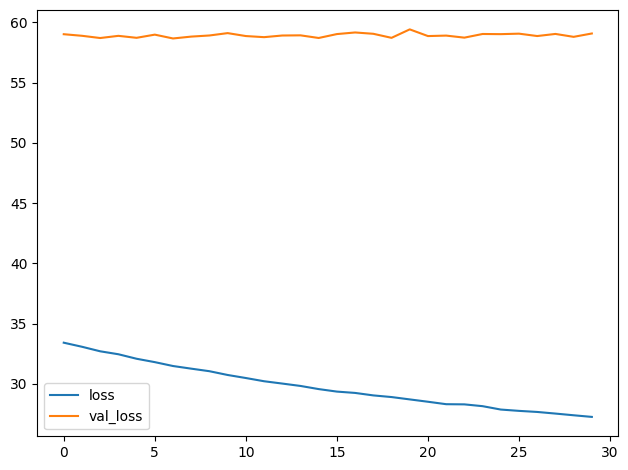

In [27]:
show_history(history)

In [28]:
def show_plot(midi_data):
    sns.heatmap(midi_data)
    plt.show()
    
def load_wav(filename):
    len_seq = 0.1
    y, sr = librosa.load(filename)
    num_batches = math.ceil(len(y) / (sr * len_seq))
    y = np.pad(y, (0, int(sr * len_seq * num_batches) - len(y)), 'constant')
    input_data = y.reshape(num_batches, 1, int(len_seq * sr))
    return input_data

def note_to_bar(X):
    notes = []
    for timee, i in eumerate(X):
        tmp = []
        for pitch, vel in enumerate(i):
            if math.isnan(vel):
                vel = 0
            if vel != 0:
                tmp.append([timee * 5, vel, pitch])
        notes.append(tmp)
    return notes

In [29]:
X_test_path = MP3_paths[100]
Y_test_path = MIDI_paths[100]

X_test = load_wav(X_test_path)

In [30]:
_, Y_test = preprocess_wave_and_midi(Y_test_path, X_test_path, len_seq)

Y_test = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], 128)

In [31]:
prediction = model.predict(X_test)
len_in = len(prediction) * 10
notes_pred = prediction.reshape(len_in, 128)
notes_pred = np.where(notes_pred > 3, notes_pred, 0)

357/357 [==============================] - 4s 10ms/step


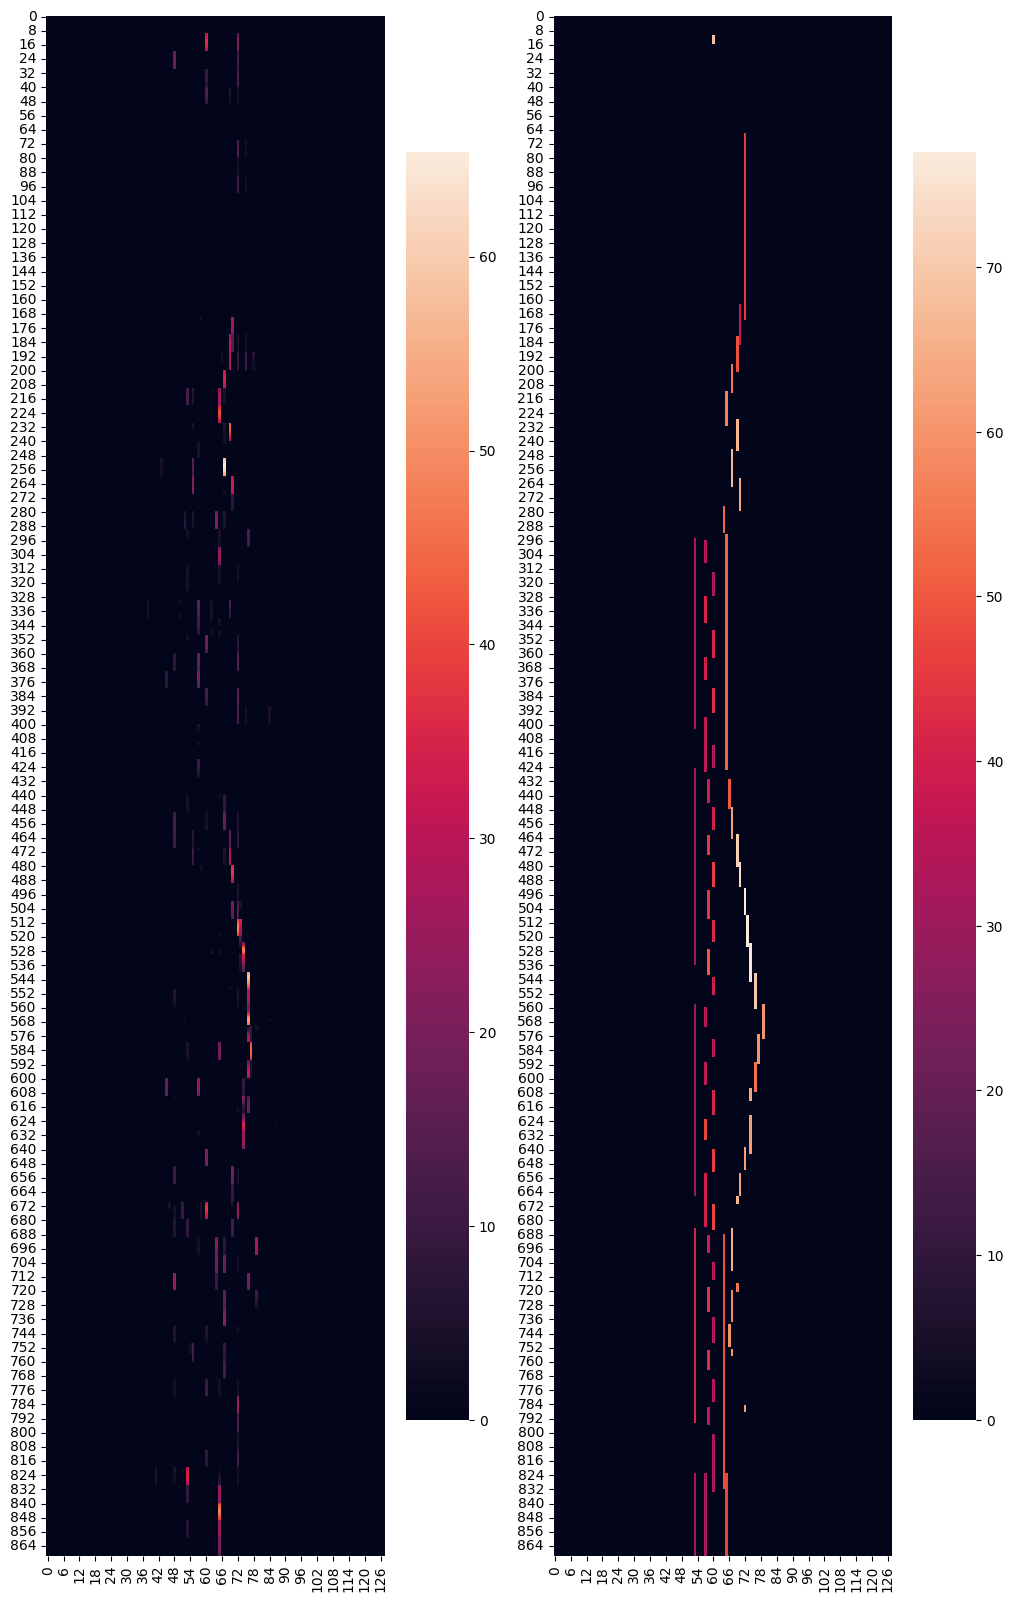

In [32]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(12,20))

sns.heatmap(notes_pred[300:1170], ax = ax)
sns.heatmap(Y_test[300:1170], ax=ax2)
plt.show()